In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [2]:
# Load the datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
# Check for missing values
print(train.isnull().sum())
print(test.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64
Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64


In [4]:
# Check categorical features
for col in train.select_dtypes(include='object'):
    print(f"\n{col}:")
    print(train[col].value_counts().head(5))


Item_Identifier:
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
Name: count, dtype: int64

Item_Fat_Content:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Item_Type:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Name: count, dtype: int64

Outlet_Identifier:
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
Name: count, dtype: int64

Outlet_Size:
Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64

Outlet_Location_Type:
Outlet_Location_Type
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: count, dtype: int64

Outlet_Type:
Outlet_Type
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: count, dtype: int64


Original Target Skewness: 1.18
Log Transformed Target Skewness: -0.88
Square Root Transformed Target Skewness: 0.23


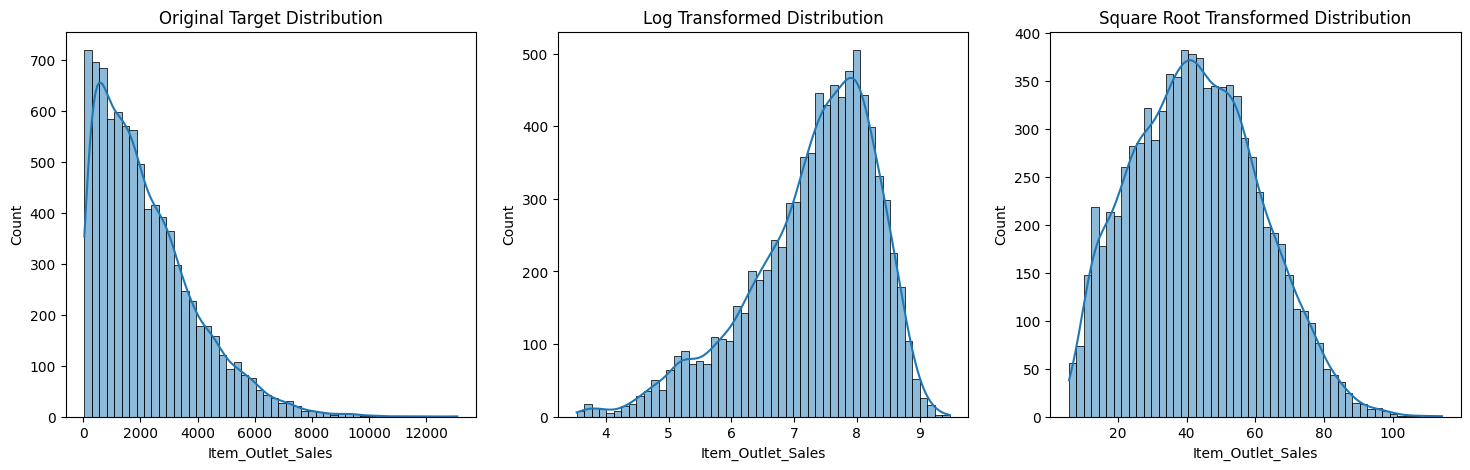

In [5]:
# Visualize the distribution of the target variable
y = train['Item_Outlet_Sales']

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(y, bins=50, kde=True)
plt.title("Original Target Distribution")
skew_value = skew(y)
print(f"Original Target Skewness: {skew_value:.2f}")

plt.subplot(1, 3, 2)
sns.histplot(np.log1p(y), bins=50, kde=True)
plt.title("Log Transformed Distribution")
skew_log = skew(np.log1p(y))
print(f"Log Transformed Target Skewness: {skew_log:.2f}")

plt.subplot(1, 3, 3)
sns.histplot(np.sqrt(y), bins=50, kde=True)
plt.title("Square Root Transformed Distribution")
skew_sqrt = skew(np.sqrt(y))
print(f"Square Root Transformed Target Skewness: {skew_sqrt:.2f}")


In [6]:
# Combine train and test for consistent cleaning
train['is_train'] = 1
test['is_train'] = 0
combined = pd.concat([train, test], ignore_index=True)

In [7]:
# Fill missing values in Item_Weight with mode for each Item_Identifier, higher chances of outliers when using mean
for each in combined['Item_Identifier'].unique():
    mode_val = combined.loc[combined["Item_Identifier"] == each, "Item_Weight"].mode()
    combined.loc[
        (combined["Item_Identifier"] == each) & (combined["Item_Weight"].isna()),
        "Item_Weight"
    ] = mode_val[0] if not mode_val.empty else np.nan

In [8]:
# Item_Visibility zeroes -> mean per Item_Identifier
for each in combined['Item_Identifier'].unique():
    mean_vis = combined.loc[
        (combined["Item_Identifier"] == each) & (combined["Item_Visibility"] != 0),
        "Item_Visibility"
    ].mean()
    combined.loc[
        (combined["Item_Identifier"] == each) & (combined["Item_Visibility"] == 0),
        "Item_Visibility"
    ] = mean_vis

In [9]:
# Outlet_Size missing values
print(combined.loc[combined["Outlet_Size"].isnull(),"Outlet_Identifier"].value_counts())

# Check Outlet_Size missing values for specific Outlet_Identifier
print("Outlet_045 missing values:")
display(combined.loc[(combined["Outlet_Size"].isnull()) & (combined["Outlet_Identifier"] == "OUT045") ,].describe(include = [object]))


# Check Outlet_Size missing values for specific Outlet_Identifier
print("Outlet_017 missing values:")
display(combined.loc[(combined["Outlet_Size"].isnull()) & (combined["Outlet_Identifier"] == "OUT017") ,].describe(include = [object]))

# Check Outlet_Size missing values for specific Outlet_Identifier
print("Outlet_010 missing values:")
display(combined.loc[(combined["Outlet_Size"].isnull()) & (combined["Outlet_Identifier"] == "OUT010") ,].describe(include = [object]))

print("Outlet_010 missing values:")
display(combined.loc[(combined["Outlet_Size"].isnull()) & (combined["Outlet_Identifier"] == "OUT010") ,].describe(include = [object]))

print("Outlet Size for Tier 2 Supermarket Type1:")
display(combined.loc[(combined["Outlet_Location_Type"]== "Tier 2") & (combined["Outlet_Type"]=="Supermarket Type1") ,"Outlet_Size"].value_counts())

print("Outlet Size for Tier 3 Grocery Store:")
display(combined.loc[(combined["Outlet_Location_Type"]== "Tier 3") & (combined["Outlet_Type"]=="Grocery Store") ,"Outlet_Size"].value_counts())

# Since the series is empty, checking for individual Outlet_Identifier
display(combined.loc[(combined["Outlet_Type"]=="Grocery Store") ,"Outlet_Size"].value_counts())
display(combined.loc[(combined["Outlet_Location_Type"]== "Tier 3") ,"Outlet_Size"].value_counts())

# Since Medium has the highest count, we can fill missing values with "Medium"
# Filling Outlet_Size for OUT045 and OUT017 with "Small" based on the analysis
#TODO: Check if this is the best approach

combined.loc[
    (combined["Outlet_Size"].isnull()) & (combined["Outlet_Identifier"].isin(["OUT045", "OUT017"])),
    "Outlet_Size"
] = "Small"
combined['Outlet_Size'] = combined['Outlet_Size'].fillna("Medium")


Outlet_Identifier
OUT045    1548
OUT017    1543
OUT010     925
Name: count, dtype: int64
Outlet_045 missing values:


,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,1548,1548,1548,1548,0,1548,1548
unique,1548,5,16,1,0,1,1
top,FDH17,Low Fat,Fruits and Vegetables,OUT045,NaN,Tier 2,Supermarket Type1
freq,1,932,218,1548,NaN,1548,1548


Outlet_017 missing values:


,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,1543,1543,1543,1543,0,1543,1543
unique,1543,5,16,1,0,1,1
top,FDU28,Low Fat,Snack Foods,OUT017,NaN,Tier 2,Supermarket Type1
freq,1,928,219,1543,NaN,1543,1543


Outlet_010 missing values:


,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,925,925,925,925,0,925,925
unique,925,5,16,1,0,1,1
top,FDX07,Low Fat,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
freq,1,543,137,925,NaN,925,925


Outlet_010 missing values:


,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,925,925,925,925,0,925,925
unique,925,5,16,1,0,1,1
top,FDX07,Low Fat,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
freq,1,543,137,925,NaN,925,925


Outlet Size for Tier 2 Supermarket Type1:


Outlet_Size
Small    1550
Name: count, dtype: int64

Outlet Size for Tier 3 Grocery Store:


Series([], Name: count, dtype: int64)

Outlet_Size
Small    880
Name: count, dtype: int64

Outlet_Size
Medium    3105
High      1553
Name: count, dtype: int64

In [10]:
# Outlet age
CURRENT_YEAR = 2025
combined['Outlet_Age'] = CURRENT_YEAR - combined['Outlet_Establishment_Year']

# MRP price bins
combined['MRP_bin'] = pd.qcut(combined['Item_MRP'], q=4, labels=['Low', 'Medium', 'High', 'Very_High'])

# Per-unit visibility = visibility / weight
combined['Vis_per_Weight'] = combined['Item_Visibility'] / (combined['Item_Weight'] + 1e-6)

# Flag for "new" outlets (under 10 years old)
combined['Is_New_Outlet'] = (combined['Outlet_Age'] < 10).astype(int)

In [11]:
# Split back into train and test sets
train = combined[combined['is_train'] == 1].drop(columns=['is_train']).copy()
test  = combined[combined['is_train'] == 0].drop(columns=['is_train']).copy()

In [12]:
# Check for missing values again
print(train.isnull().sum())
print(test.isnull().sum())

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Outlet_Age                   0
MRP_bin                      0
Vis_per_Weight               0
Is_New_Outlet                0
dtype: int64
Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
Outlet_Age                      0
MRP_bin                         0
Vis_per_Weight 

In [13]:
train.to_csv('./data/cleaned_train.csv', index=False)
test.to_csv('./data/cleaned_test.csv', index=False)